In [1]:
from ultralytics import YOLO
import cv2
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.9.0+cu126
True
12.6


In [5]:
model = YOLO("yolov12n.pt")


0: 448x640 3 cars, 1 truck, 1 stop sign, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


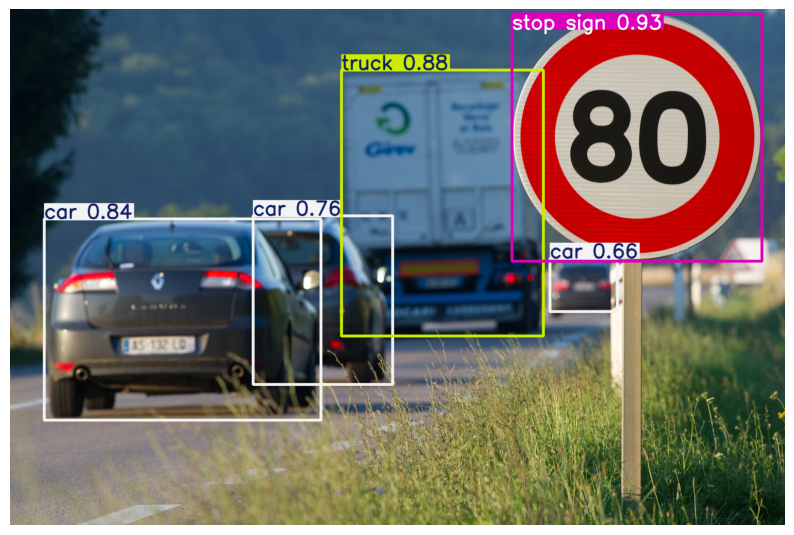

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [14]:
def detect(img_path, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    image = cv2.imread(img_path)
    results = model.predict(image)

    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image_rgb)
    plt.axis('off')
    plt.show()
    print(results[0].names)

    for i, box in enumerate(results[0].boxes):
        class_id = int(box.cls)
        class_name = results[0].names[class_id]

        x1, y1, x2, y2 = box.xyxy[0].tolist()
        confidence = float(box.conf)

        if confidence < 0.5:
            continue

        print(f'#{i}: Class={class_name}, Cords: (x1={x1:.2f}, y1={y1:.2f})(x2={x2:.2f}, y2={y2:.2f}), Conf={confidence}')


detect("lxjh2x6rv0finbsjv17qmu7hi1hsr1jv.jpeg", model)

За основу взят датасет https://public.roboflow.com/object-detection/vehicles-openimages

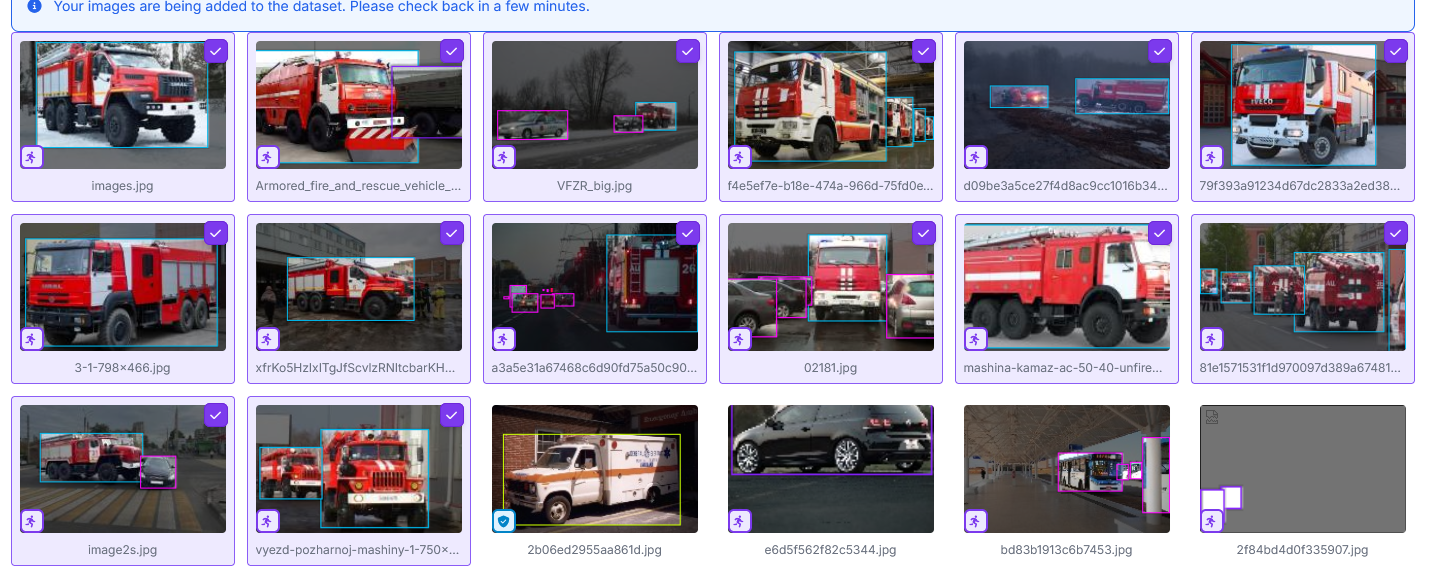

Добавил фото с новым классом и разметил

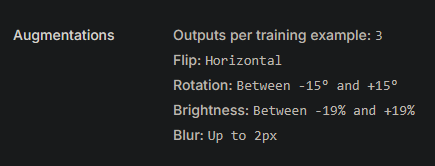


0: 416x640 1 truck, 44.0ms
Speed: 1.1ms preprocess, 44.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


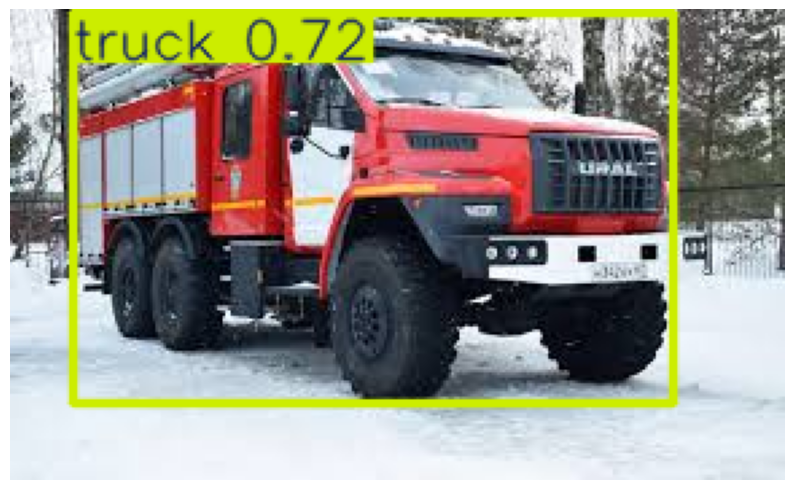

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [15]:
detect("firetruck_raw/images.jpg", model)

Пожарную машину можель, очевидно, распознает как truck

In [24]:
from roboflow import Roboflow
key = open('key.txt', 'r')
rf = Roboflow(api_key=key.read())
key.close()

project = rf.project("vehicles-openimages-hic1u")
version = project.version(3)
dataset = version.download("yolov12")

Exporting format yolov12 in progress : 85.0%
Version export complete for yolov12 format



Extracting Dataset Version Zip to Vehicles-OpenImages-3 in yolov12:: 100%|██████████| 3112/3112 [00:00<00:00, 3377.85it/s]


In [26]:
import os
import glob
from ultralytics import YOLO
import csv
import matplotlib.pyplot as plt 

In [28]:
all_ckpts = sorted(glob.glob(os.path.join('train/ckpt', "*.pt")), key=os.path.getctime)
resume_ckpt = all_ckpts[-1] if all_ckpts else None
print("Resume from:", resume_ckpt)

def custom_batch_callback(trainer):
    if hasattr(trainer, 'batch_i') and trainer.batch_i is not None:
        batch_idx = trainer.batch_i + trainer.epoch * len(trainer.train_loader)
        if batch_idx > 0 and batch_idx % 5 == 0:
            fname = f"ckpt_step{batch_idx}.pt"
            path = os.path.join('train/ckpt', fname)
            print(f"Saving checkpoint: {path}")
            trainer.model.save(path)
            ckpts = sorted(glob.glob(os.path.join('train/ckpt', "*.pt")), key=os.path.getctime)
            if len(ckpts) > 5:
                for obsolete in ckpts[:-5]:
                    os.remove(obsolete)

model = YOLO('yolov12n.pt')
model.add_callback('on_train_batch_end', custom_batch_callback)

results = model.train(
    data='Vehicles-OpenImages-3/data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    workers=4,
    resume=resume_ckpt
)


# Построение графика precision
try:
    # Чтение результатов из CSV-файла
    results_csv = os.path.join(results.save_dir, 'results.csv')
    
    if os.path.exists(results_csv):
        # Чтение данных
        epochs = []
        precisions = []
        with open(results_csv, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if 'metrics/precision(B)' in row:
                    epochs.append(int(row['epoch']))
                    precisions.append(float(row['metrics/precision(B)']))
        
        # Построение графика
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, precisions, marker='o', linestyle='-', color='b')
        plt.xlabel('Эпоха')
        plt.ylabel('Precision')
        plt.title('Метрика Precision на валидационных данных')
        plt.grid(True)
        
        # Сохранение графика
        plot_path = os.path.join('train/ckpt', 'validation_precision.png')
        plt.savefig(plot_path)
        plt.close()
        print(f"\nГрафик precision сохранён: {plot_path}")
    else:
        print("\nФайл с результатами не найден")

except Exception as e:
    print(f"\nОшибка при построении графика: {e}")

Resume from: None
Ultralytics 8.3.217  Python-3.13.3 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Vehicles-OpenImages-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

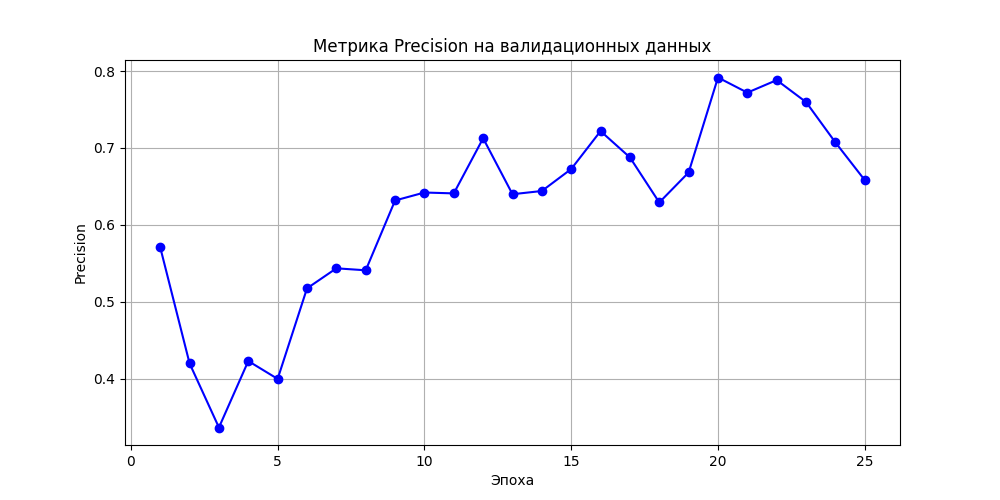

In [29]:
model.save("yolo_trained.pt")


0: 416x640 1 Firetruck, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


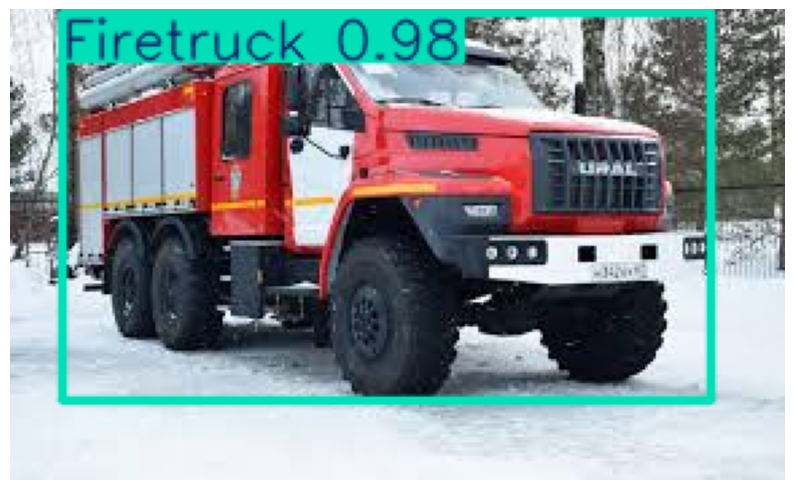

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=19.90, y1=1.30)(x2=260.98, y2=145.63), Conf=0.9767797589302063


In [30]:
detect("firetruck_raw/images.jpg", model)


0: 384x640 7 Cars, 1 Firetruck, 42.8ms
Speed: 5.8ms preprocess, 42.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


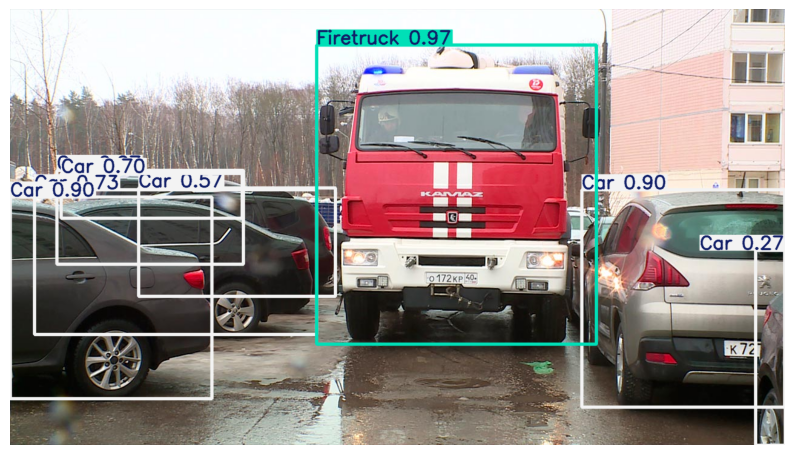

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=506.32, y1=59.63)(x2=968.19, y2=553.98), Conf=0.974054753780365
#1: Class=Car, Cords: (x1=944.12, y1=298.37)(x2=1279.24, y2=657.02), Conf=0.9034496545791626
#2: Class=Car, Cords: (x1=0.00, y1=310.88)(x2=333.20, y2=643.14), Conf=0.9018021821975708
#3: Class=Car, Cords: (x1=40.95, y1=298.53)(x2=506.12, y2=537.52), Conf=0.729363739490509
#4: Class=Car, Cords: (x1=84.35, y1=271.06)(x2=383.37, y2=345.56), Conf=0.6967346668243408
#5: Class=Car, Cords: (x1=213.00, y1=295.11)(x2=537.69, y2=474.70), Conf=0.567841112613678

0: 384x640 1 Firetruck, 12.7ms
Speed: 1.0ms preprocess, 12.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


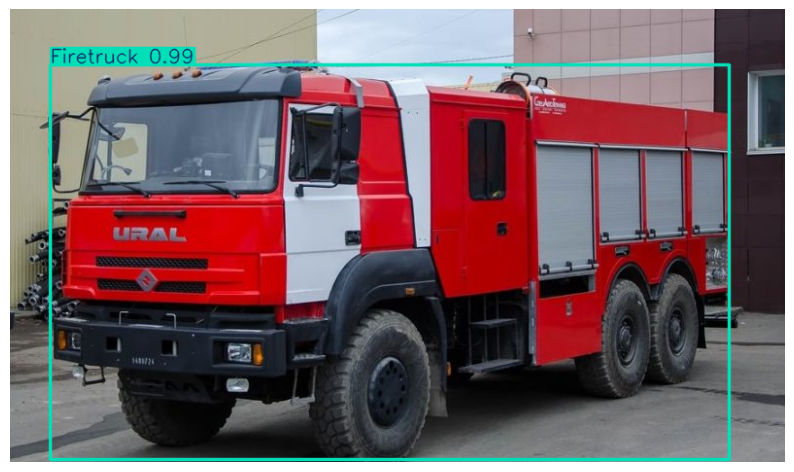

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=41.61, y1=57.55)(x2=740.30, y2=463.85), Conf=0.988471269607544

0: 448x640 1 Firetruck, 16.9ms
Speed: 1.7ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


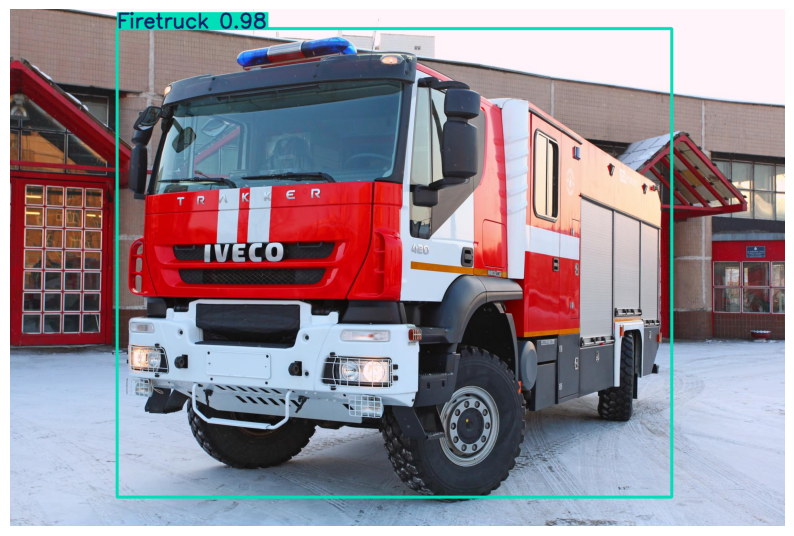

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=265.07, y1=48.66)(x2=1639.23, y2=1208.20), Conf=0.9823645949363708

0: 448x640 5 Firetrucks, 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


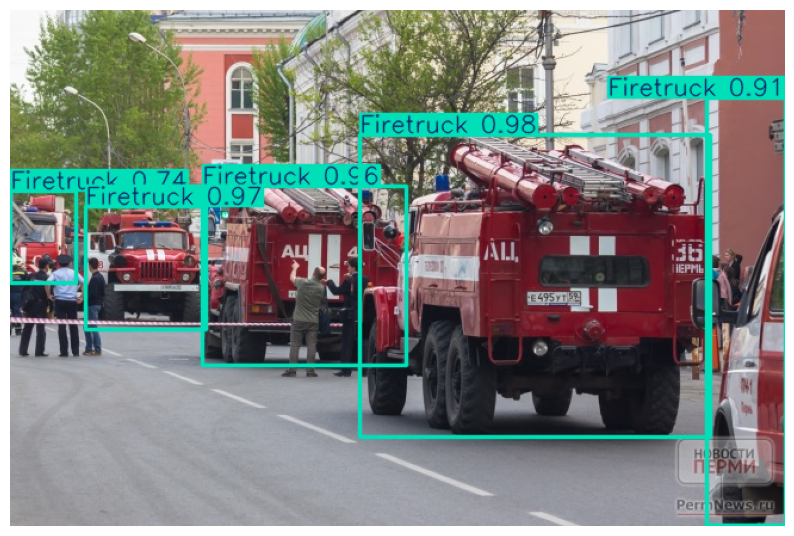

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=293.61, y1=105.81)(x2=587.41, y2=358.04), Conf=0.9793206453323364
#1: Class=Firetruck, Cords: (x1=63.76, y1=165.30)(x2=164.15, y2=268.16), Conf=0.9734848141670227
#2: Class=Firetruck, Cords: (x1=161.98, y1=148.62)(x2=332.85, y2=298.78), Conf=0.9611361622810364
#3: Class=Firetruck, Cords: (x1=584.81, y1=74.85)(x2=650.00, y2=432.18), Conf=0.9059112668037415
#4: Class=Firetruck, Cords: (x1=0.42, y1=152.93)(x2=55.40, y2=229.71), Conf=0.743671178817749

0: 448x640 4 Cars, 1 Firetruck, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


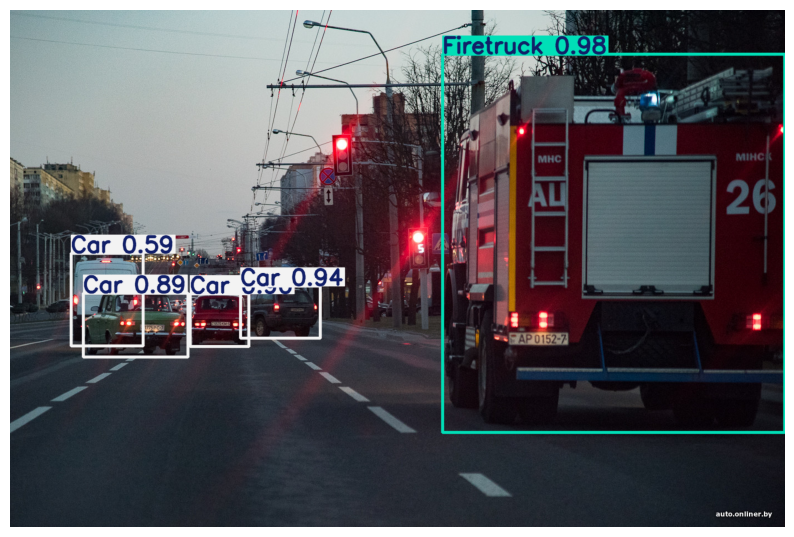

{0: 'Ambulance', 1: 'Bus', 2: 'Car', 3: 'Firetruck', 4: 'Motorcycle', 5: 'Truck'}
#0: Class=Firetruck, Cords: (x1=781.60, y1=81.17)(x2=1399.19, y2=763.05), Conf=0.9807515144348145
#1: Class=Car, Cords: (x1=416.29, y1=499.81)(x2=560.85, y2=593.56), Conf=0.9374732375144958
#2: Class=Car, Cords: (x1=325.70, y1=513.62)(x2=431.84, y2=608.65), Conf=0.9038487672805786
#3: Class=Car, Cords: (x1=132.93, y1=512.95)(x2=321.33, y2=627.64), Conf=0.8851761221885681
#4: Class=Car, Cords: (x1=110.35, y1=440.95)(x2=240.75, y2=607.88), Conf=0.5941070318222046


In [36]:
import os
for file in os.listdir('firetruck_raw')[:5]:
    detect(f'firetruck_raw/{file}', model)